In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc

# Trajectories from TEUFEL tracking

### Probe file

In [100]:
FileName = "/home/lehnertu/Programming/TEUFEL/csr2d_probe.h5"
hdf = h5py.File(FileName, "r")

In [101]:
hdf.keys()

<KeysViewHDF5 ['Probe']>

In [102]:
dataset = hdf['Probe']
dataset

<HDF5 dataset "Probe": shape (2001, 1, 16), type "<f8">

In [103]:
timesteps = np.array(dataset)[:,0,0]
traj = np.array(dataset)[:,0,1:7]
traj.shape

(2001, 6)

In [104]:
hdf.close()

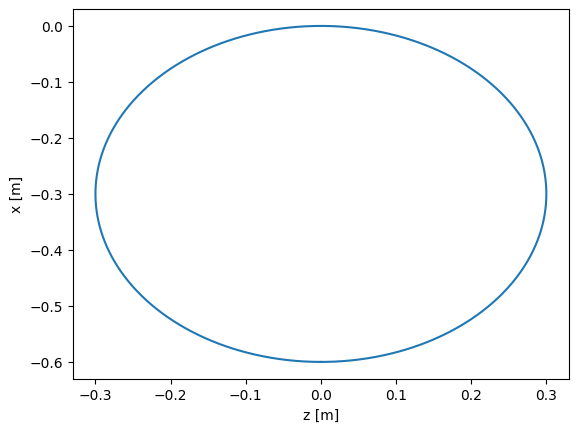

In [105]:
x = traj[:,0]
z = traj[:,2]

plt.plot(z,x)
plt.xlabel('z [m]')
plt.ylabel('x [m]')
plt.show()

In [106]:
traj[0]

array([ -0.6      ,   0.       ,   0.       ,   0.       ,   0.       ,
       -97.8424498])

In [107]:
traj[1000]

array([-2.79175794e-10,  0.00000000e+00,  3.87895555e-07, -1.26508845e-04,
        0.00000000e+00,  9.78424498e+01])

In [108]:
traj[2000]

array([-6.00000000e-01,  0.00000000e+00, -7.75791254e-07,  2.53017723e-04,
        0.00000000e+00, -9.78424498e+01])

### check length, timing and 2nd order accuracy 

In [109]:
X0 = traj[1000,0:3]
X1 = traj[1001,0:3]

In [110]:
BG0 = traj[1000,3:]
BG1 = traj[1001,3:]
BG = 0.5*(BG0+BG1)

In [111]:
Gamma = np.sqrt( np.dot(BG,BG) + 1.0)
print(Gamma)
Beta = BG/Gamma
print(Beta)

97.84743922267715
[-0.00157201  0.          0.99994654]


In [112]:
R = 0.3
L = R*2*np.pi
t = L/(np.linalg.norm(Beta)*sc.c)
dt = t / 2000
print(f'dt = {dt:.6g} s')

dt = 3.14393e-12 s


In [113]:
timesteps[1]-timesteps[0]

3.1439317258570202e-12

In [114]:
print(X0+Beta*sc.c*dt)
print(X1)

[-1.48193844e-06  0.00000000e+00  9.42864527e-04]
[-1.48193844e-06  0.00000000e+00  9.42864527e-04]


# Investigate computation warnings

In [179]:
# the snapshot is done at i=1000, so this is the time of observation
obs_time = timesteps[1000]
obs_point = np.array([0,0,-4.0e-6])
i1 = 999
X1 = traj[i1,0:3]
bg1 =  traj[i1,3:6]
bg = np.linalg.norm(bg1)
gamma = np.sqrt(bg**2+1)
print(timesteps[i1],X1,bg1/gamma)
R1 = np.linalg.norm(X1-obs_point)
t1 = obs_time - (timesteps[i1] + R1 / sc.c)
print(R1,t1)
i2 = 1000
X2 = traj[i2,0:3]
bg2 =  traj[i2,3:6]
bg = np.linalg.norm(bg1)
gamma = np.sqrt(bg**2+1)
print(timesteps[i2],X2,bg2/gamma)
R2 = np.linalg.norm(X2-obs_point)
t2 = obs_time - (timesteps[i2] + R2 / sc.c)
print(R2,t2)

3.140787794131145e-09 [-1.47950123e-06  0.00000000e+00 -9.42088740e-04] [0.00314013 0.         0.99994284]
0.0009380899062707193 1.4800617859831736e-14
3.1439317258570018e-09 [-2.79175794e-10  0.00000000e+00  3.87895555e-07] [-1.29291773e-06  0.00000000e+00  9.99947775e-01]
4.387895563635767e-06 -1.4636444134877075e-14


In [180]:
timesteps[i2]-timesteps[i1]

3.1439317258569095e-12

In [130]:
frac = t1/(t1-t2)
frac

0.5027885548663819

In [133]:
SourceT = timesteps[i1]*(1.0-frac) + timesteps[i2]*frac
SourceX = X1*(1.0-frac) + X2*frac
print(SourceT,SourceX)
R = np.linalg.norm(SourceX-obs_point)
dt = obs_time - (SourceT + R / sc.c)
print(R,dt)

3.142368527020187e-09 [-7.35765310e-07  0.00000000e+00 -4.68222274e-04]
0.0004642228572765435 1.4718063237471355e-14


In [148]:
frac = 0.99767
SourceT = timesteps[i1]*(1.0-frac) + timesteps[i2]*frac
SourceX = X1*(1.0-frac) + X2*frac
print(SourceT,SourceX)
R = np.linalg.norm(SourceX-obs_point)
dt = obs_time - (SourceT + R / sc.c)
print(R,dt)

3.1439244004960807e-09 [-3.72576317e-09  0.00000000e+00 -1.80807501e-06]
2.1919281613586957e-06 1.3875582130711084e-17


<b>The dependency of the observation time on frac is highly nonlinear.<br>
If we are close to one trajectory point there are significant changes only very near that point.</b>

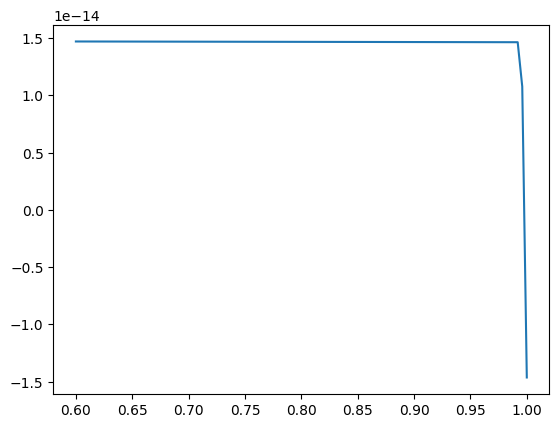

In [161]:
frac = np.linspace(0.6,1.0,100)
ObsT = []
for f in frac:
    SourceT = timesteps[i1]*(1.0-f) + timesteps[i2]*f
    SourceX = X1*(1.0-f) + X2*f
    R = np.linalg.norm(SourceX-obs_point)
    dt = obs_time - (SourceT + R / sc.c)
    ObsT.append(dt)
plt.plot(frac,ObsT)
plt.show()

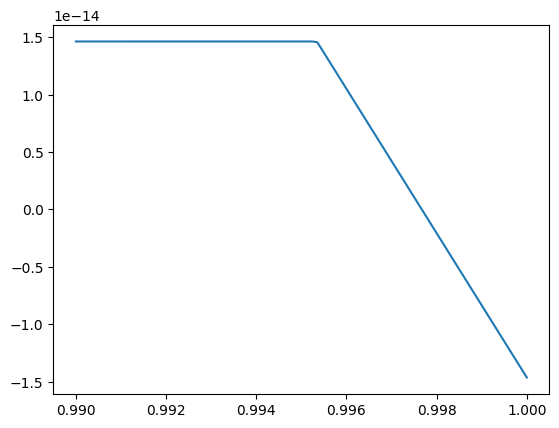

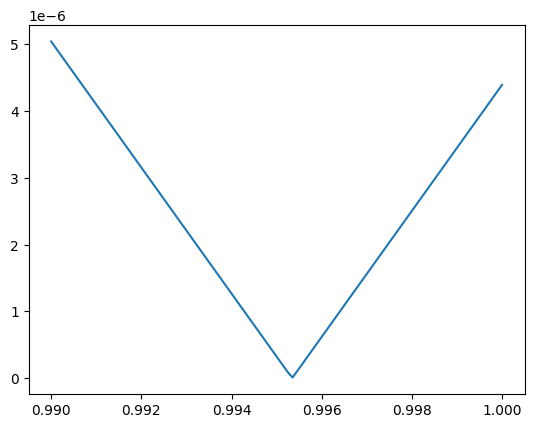

In [176]:
frac = np.linspace(0.99,1.0,100)
Dist = []
ObsT = []
for f in frac:
    SourceT = timesteps[i1]*(1.0-f) + timesteps[i2]*f
    SourceX = X1*(1.0-f) + X2*f
    R = np.linalg.norm(SourceX-obs_point)
    dt = obs_time - (SourceT + R / sc.c)
    Dist.append(R)
    ObsT.append(dt)
plt.plot(frac,ObsT)
plt.show()
plt.plot(frac,Dist)
plt.show()

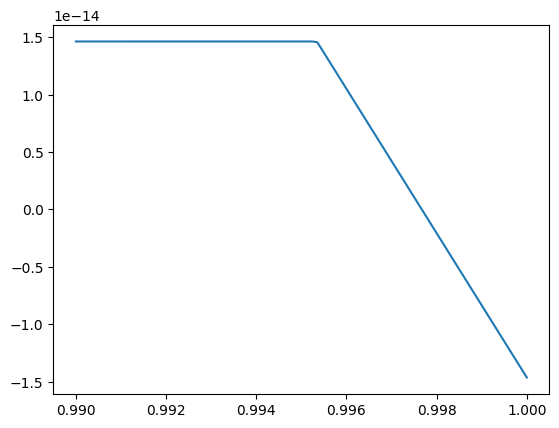

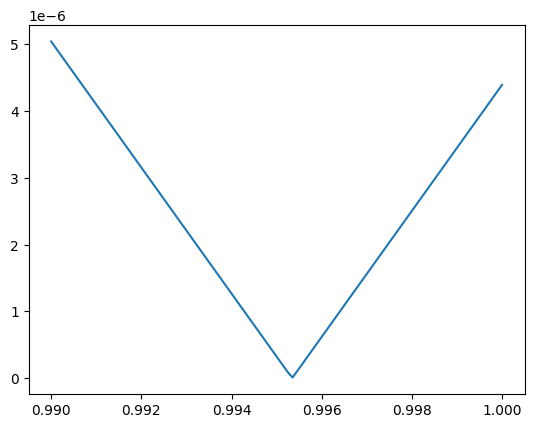

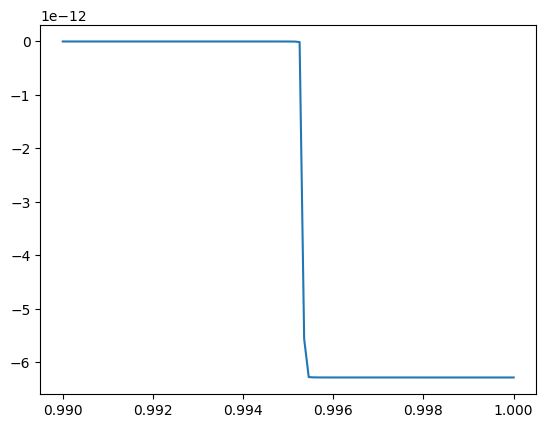

In [183]:
frac = np.linspace(0.99,1.0,100)
eps = 1e-6
Dist = []
ObsT = []
dTdf = []
for f in frac:
    SourceT = timesteps[i1]*(1.0-f) + timesteps[i2]*f
    SourceTp = timesteps[i1]*(1.0-(f+eps)) + timesteps[i2]*(f+eps)
    SourceTm = timesteps[i1]*(1.0-(f-eps)) + timesteps[i2]*(f-eps)
    SourceX = X1*(1.0-f) + X2*f
    SourceXp = X1*(1.0-(f+eps)) + X2*(f+eps)
    SourceXm = X1*(1.0-(f-eps)) + X2*(f-eps)
    R = np.linalg.norm(SourceX-obs_point)
    Rp = np.linalg.norm(SourceXp-obs_point)
    Rm = np.linalg.norm(SourceXm-obs_point)
    dt = obs_time - (SourceT + R / sc.c)
    Dist.append(R)
    ObsT.append(dt)
    dTdf.append((SourceTm-SourceTp)/(2*eps)+(Rm-Rp)/(2*eps*sc.c))
plt.plot(frac,ObsT)
plt.show()
plt.plot(frac,Dist)
plt.show()
plt.plot(frac,dTdf)
plt.show()

In [184]:
# the snapshot is done at i=1000, so this is the time of observation
obs_time = timesteps[1000]
obs_point = np.array([-0.0001,0,-2.0e-5])
i1 = 999
X1 = traj[i1,0:3]
print(timesteps[i1],X1)
R1 = np.linalg.norm(X1-obs_point)
t1 = obs_time - (timesteps[i1] + R1 / sc.c)
print(R1,t1)
i2 = 1000
X2 = traj[i2,0:3]
print(timesteps[i2],X2)
R2 = np.linalg.norm(X2-obs_point)
t2 = obs_time - (timesteps[i2] + R2 / sc.c)
print(R2,t2)

3.140787794131145e-09 [-1.47950123e-06  0.00000000e+00 -9.42088740e-04]
0.0009273370111965414 5.066841502154874e-14
3.1439317258570018e-09 [-2.79175794e-10  0.00000000e+00  3.87895555e-07]
0.00010205689810135725 -3.4042516873921175e-13


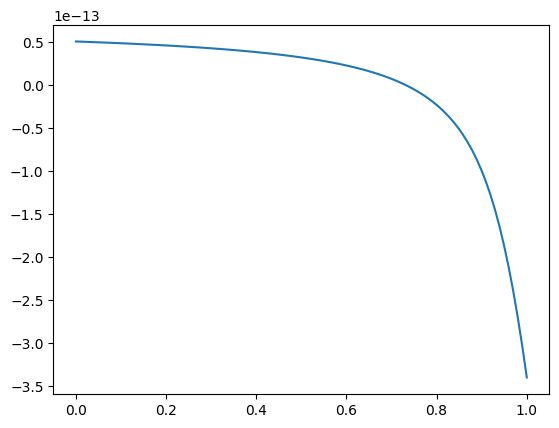

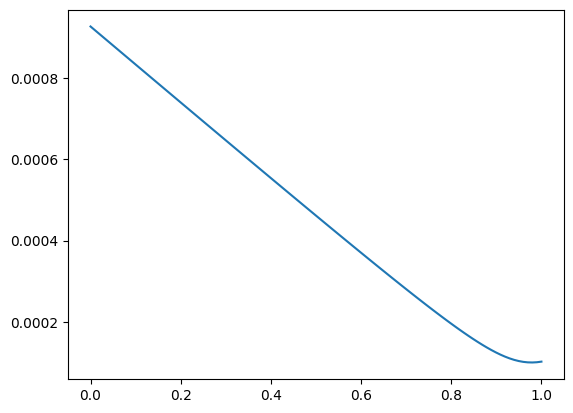

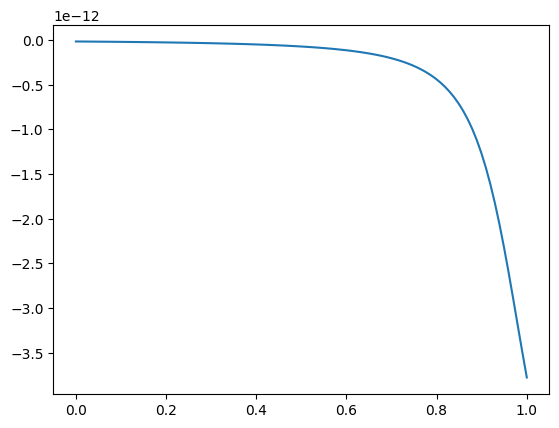

In [185]:
frac = np.linspace(0.0,1.0,100)
eps = 1e-6
Dist = []
ObsT = []
dTdf = []
for f in frac:
    SourceT = timesteps[i1]*(1.0-f) + timesteps[i2]*f
    SourceTp = timesteps[i1]*(1.0-(f+eps)) + timesteps[i2]*(f+eps)
    SourceTm = timesteps[i1]*(1.0-(f-eps)) + timesteps[i2]*(f-eps)
    SourceX = X1*(1.0-f) + X2*f
    SourceXp = X1*(1.0-(f+eps)) + X2*(f+eps)
    SourceXm = X1*(1.0-(f-eps)) + X2*(f-eps)
    R = np.linalg.norm(SourceX-obs_point)
    Rp = np.linalg.norm(SourceXp-obs_point)
    Rm = np.linalg.norm(SourceXm-obs_point)
    dt = obs_time - (SourceT + R / sc.c)
    Dist.append(R)
    ObsT.append(dt)
    dTdf.append((SourceTm-SourceTp)/(2*eps)+(Rm-Rp)/(2*eps*sc.c))
plt.plot(frac,ObsT)
plt.show()
plt.plot(frac,Dist)
plt.show()
plt.plot(frac,dTdf)
plt.show()

A refinement of the retardation point should use a Newton algorithm starting from the last point of the interval,
because the derivative of the observation time with respect to the fraction is highest
when the particle has already passed the observation point and very low while it is approaching.

# Snapshot from TEUFEL tracking

In [246]:
FileName = "/home/lehnertu/Programming/TEUFEL/csr2d_snap_1000.h5"

# open the file
hdf = h5py.File(FileName, "r")
print(hdf)
print(hdf.keys())
# Get the groups
pos_group = hdf['ObservationPosition']
Nx = pos_group.attrs.get('Nx')
Ny = pos_group.attrs.get('Ny')
print(pos_group)
print("Nx=%d Ny=%d" % (Nx,Ny))
field_group = hdf['ElMagField']
print(field_group)
par_group = hdf['ParticleCoordinates']
N_par = par_group.attrs.get('N_particles')
print(par_group)
print("Npart=%d" % N_par)
# get the data
pos = np.array(pos_group)
A = np.array(field_group)
coo = np.array(par_group)
hdf.close()

<HDF5 file "csr2d_snap_1000.h5" (mode r)>
<KeysViewHDF5 ['ElMagField', 'ObservationPosition', 'ParticleCoordinates']>
<HDF5 dataset "ObservationPosition": shape (101, 251, 3), type "<f8">
Nx=101 Ny=251
<HDF5 dataset "ElMagField": shape (101, 251, 6), type "<f8">
<HDF5 dataset "ParticleCoordinates": shape (1, 6), type "<f8">
Npart=1


In [247]:
Ex = A[:,:,0]
Ey = A[:,:,1]
Ez = A[:,:,2]
Bx = A[:,:,3]
By = A[:,:,4]
Bz = A[:,:,5]

In [248]:
x_part = 1e3*coo[:,0]
z_part = 1e3*coo[:,2]
print(x_part)
print(z_part)

[-2.79175802e-07]
[0.0003879]


In [249]:
print(pos.shape)
x = 1e3*pos[:,:,0]
print(np.min(x), np.max(x))
z = 1e3*pos[:,:,2]
print(np.min(z), np.max(z))

(101, 251, 3)
-2.5 2.5
-0.25 0.25


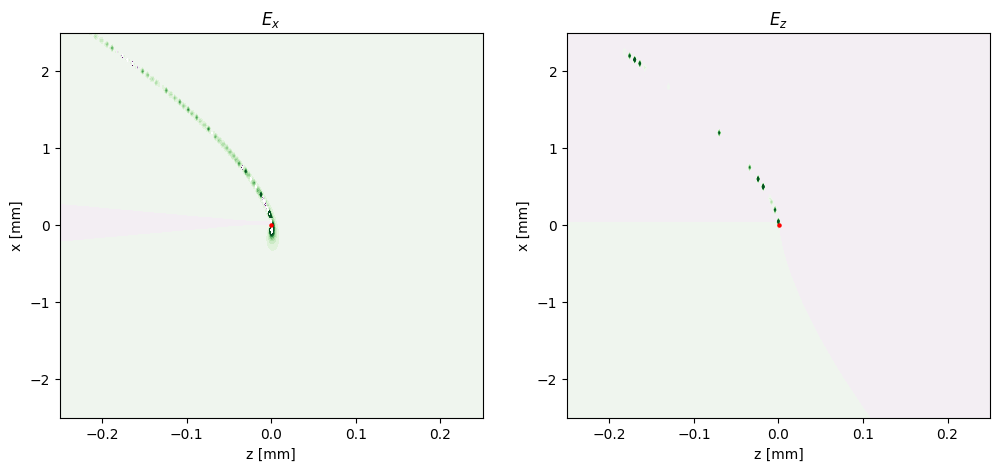

In [251]:
emax = 2e10
elevels = np.linspace(-emax, emax, num=21)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.contourf(z,x,Ex,elevels,cmap='PRGn')
ax1.set_xlabel('z [mm]')
ax1.set_ylabel('x [mm]')
ax1.scatter(z_part,x_part,c='r',s=5)
ax1.set_title('$E_x$')
ax2.contourf(z,x,Ez,elevels,cmap='PRGn')
ax2.set_xlabel('z [mm]')
ax2.set_ylabel('x [mm]')
ax2.scatter(z_part,x_part,c='r',s=5)
ax2.set_title('$E_z$')
plt.show()